In [15]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest, f_regression

In [16]:
# Load dataset
dataset_path = '/content/top5_leagues_player.csv'
data = pd.read_csv(dataset_path)

In [17]:
# Menampilkan informasi awal tentang dataset
print("Info Dataset:")
print(data.info())
print("\nSample Data:")
print(data.head())

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2612 entries, 0 to 2611
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2612 non-null   int64  
 1   name              2612 non-null   object 
 2   full_name         1480 non-null   object 
 3   age               2612 non-null   int64  
 4   height            2601 non-null   float64
 5   nationality       2612 non-null   object 
 6   place_of_birth    2595 non-null   object 
 7   price             2602 non-null   float64
 8   max_price         2606 non-null   float64
 9   position          2612 non-null   object 
 10  shirt_nr          2612 non-null   int64  
 11  foot              2576 non-null   object 
 12  club              2612 non-null   object 
 13  contract_expires  2544 non-null   object 
 14  joined_club       2612 non-null   object 
 15  player_agent      2353 non-null   object 
 16  outfitter         1003 non-n

In [18]:
# Bersihkan nilai string dari kolom numerik (jika ada)
numeric_columns = ['price', 'max_price', 'age', 'goals', 'assists', 'appearances',
                   'minutes_played', 'yellow_cards', 'red_cards', 'league_value']
for col in numeric_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

In [19]:
# Menangani nilai kosong (missing values)
data.dropna(subset=numeric_columns, inplace=True)

KeyError: ['goals', 'assists', 'appearances', 'minutes_played', 'yellow_cards', 'red_cards', 'league_value']

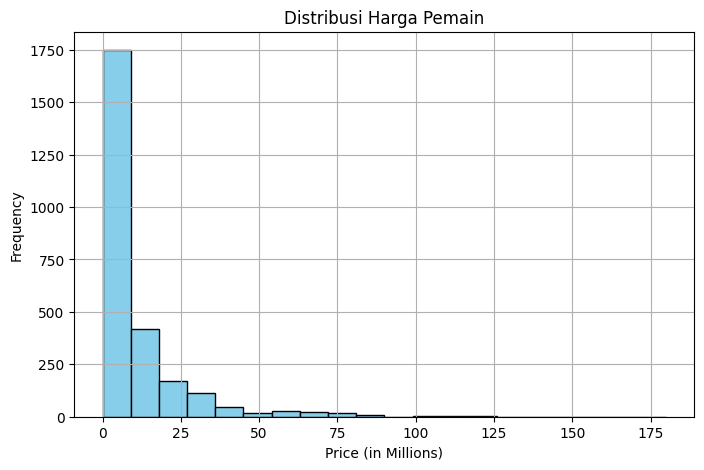

In [20]:
# Eksplorasi Data Awal
# Distribusi Harga Pemain
plt.figure(figsize=(8, 5))
data['price'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Distribusi Harga Pemain')
plt.xlabel('Price (in Millions)')
plt.ylabel('Frequency')
plt.show()

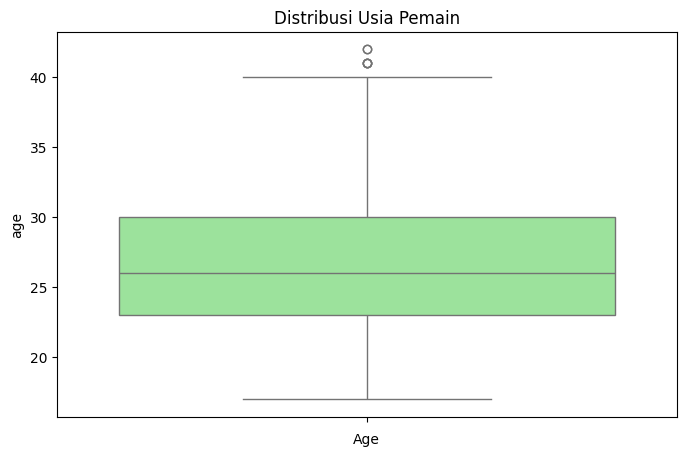

In [21]:
# Boxplot Usia Pemain
plt.figure(figsize=(8, 5))
sns.boxplot(data['age'], color='lightgreen')
plt.title('Distribusi Usia Pemain')
plt.xlabel('Age')
plt.show()

In [22]:
print(data.columns)

Index(['Unnamed: 0', 'name', 'full_name', 'age', 'height', 'nationality',
       'place_of_birth', 'price', 'max_price', 'position', 'shirt_nr', 'foot',
       'club', 'contract_expires', 'joined_club', 'player_agent', 'outfitter',
       'league'],
      dtype='object')


In [34]:
# Preprocessing: Memilih fitur yang relevan
# Only include numeric features for scaling
features = data[['price', 'max_price', 'age', 'height']]
labels = data['max_price']

In [35]:
# Seleksi Fitur menggunakan SelectKBest
try:
    if labels is not None:
        selector = SelectKBest(score_func=f_regression, k=3)  # Memilih 3 fitur terbaik
        features_selected = selector.fit_transform(features, labels)
        selected_columns = features.columns[selector.get_support()]
        print("Fitur Terpilih:", selected_columns)
    else:
        raise ValueError("Kolom 'league_value' tidak ditemukan.")
except Exception as e:
    print("Error pada seleksi fitur:", e)
    features_selected = features.values  # Menggunakan semua fitur jika terjadi error

Error pada seleksi fitur: Input X contains NaN.
SelectKBest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [36]:
# Menangani nilai kosong (jika ada)
features = features.dropna()
labels = labels.loc[features.index]

In [37]:
# Normalisasi data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [38]:
# Menentukan jumlah cluster menggunakan Elbow Method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

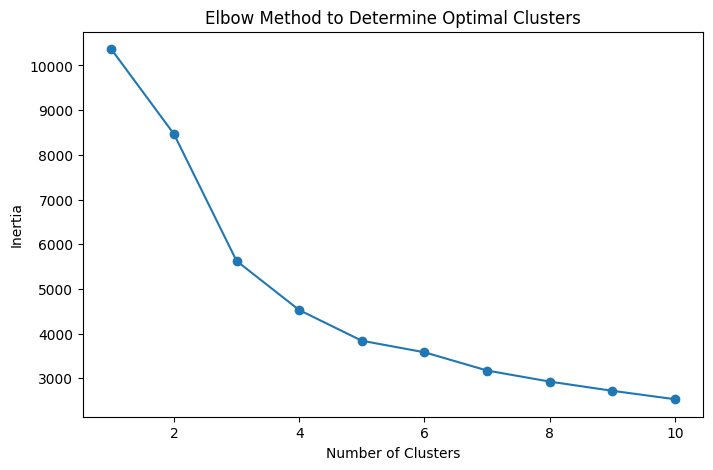

In [39]:
# Visualisasi Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [40]:
# Membuat model K-Means dengan jumlah cluster optimal
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(features_scaled)

KMeans(n_clusters=3, random_state=42)

In [41]:
# Menambahkan hasil clustering ke dataset
features['Cluster'] = kmeans.labels_

In [42]:
# Evaluasi Clustering dengan Silhouette Score
silhouette_avg = silhouette_score(features_scaled, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.2790933218592404


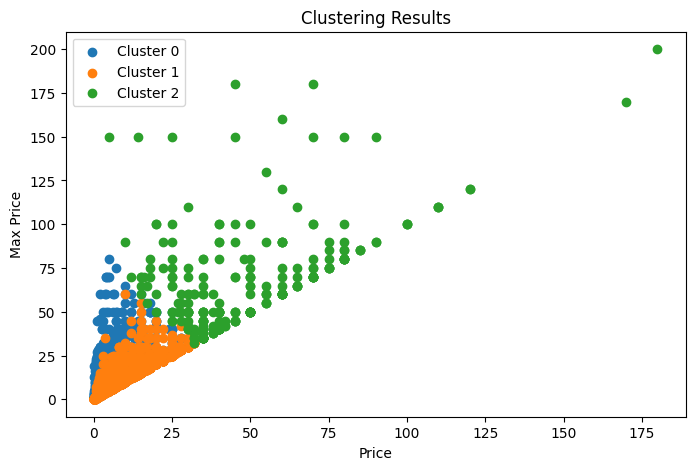

In [43]:
# Visualisasi hasil clustering
plt.figure(figsize=(8, 5))
for cluster in range(optimal_k):
    cluster_data = features[features['Cluster'] == cluster]
    plt.scatter(cluster_data['price'], cluster_data['max_price'], label=f'Cluster {cluster}')
plt.title('Clustering Results')
plt.xlabel('Price')
plt.ylabel('Max Price')
plt.legend()
plt.show()


Distribusi Cluster Berdasarkan Liga:
league   Bundesliga  EPL  LaLiga  Ligue1  Other  SerieA
Cluster                                                
0               180  150     221     135    126     138
1               283  180     214     273    250     193
2                33  117      46      18     11      23


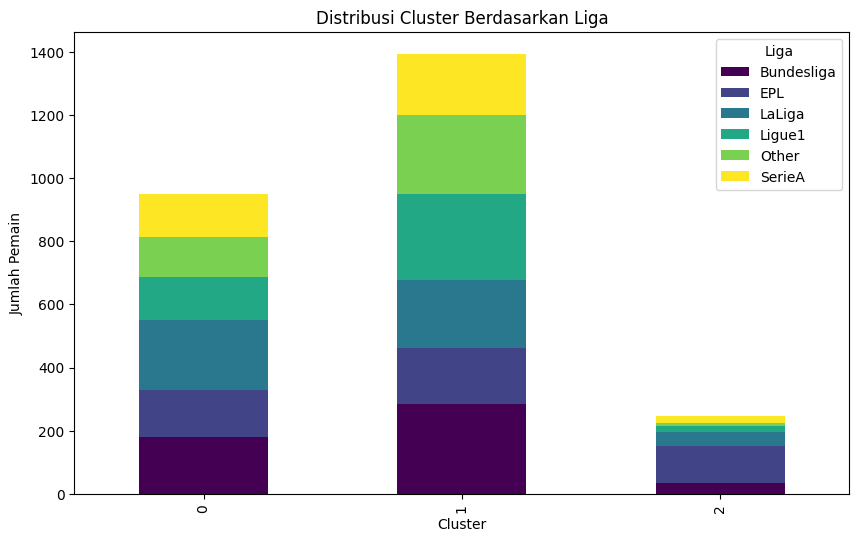

In [44]:
# Analisis Distribusi Cluster Berdasarkan Liga
if 'league' in data.columns:
    features['league'] = data['league']
    cluster_league_distribution = features.groupby(['Cluster', 'league']).size().unstack(fill_value=0)
    print("\nDistribusi Cluster Berdasarkan Liga:")
    print(cluster_league_distribution)

    # Visualisasi Distribusi Cluster per Liga
    cluster_league_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
    plt.title('Distribusi Cluster Berdasarkan Liga')
    plt.xlabel('Cluster')
    plt.ylabel('Jumlah Pemain')
    plt.legend(title='Liga')
    plt.show()

In [54]:
# Menyimpan hasil clustering ke file CSV
output_path = '/content/clustering_results.csv'
features.to_csv(output_path, index=False)
print(f"Hasil clustering disimpan di {output_path}")

Hasil clustering disimpan di /content/clustering_results.csv
